In [ ]:
import kagglehub
puneet6060_intel_image_classification_path = kagglehub.dataset_download('puneet6060/intel-image-classification')

print('Data source import complete.')


Data source import complete.


In [ ]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint ,  ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Set paths
train_dir = '/kaggle/input/intel-image-classification/seg_train/seg_train'
test_dir = '/kaggle/input/intel-image-classification/seg_test/seg_test'

# Image size
img_size = (150, 150)

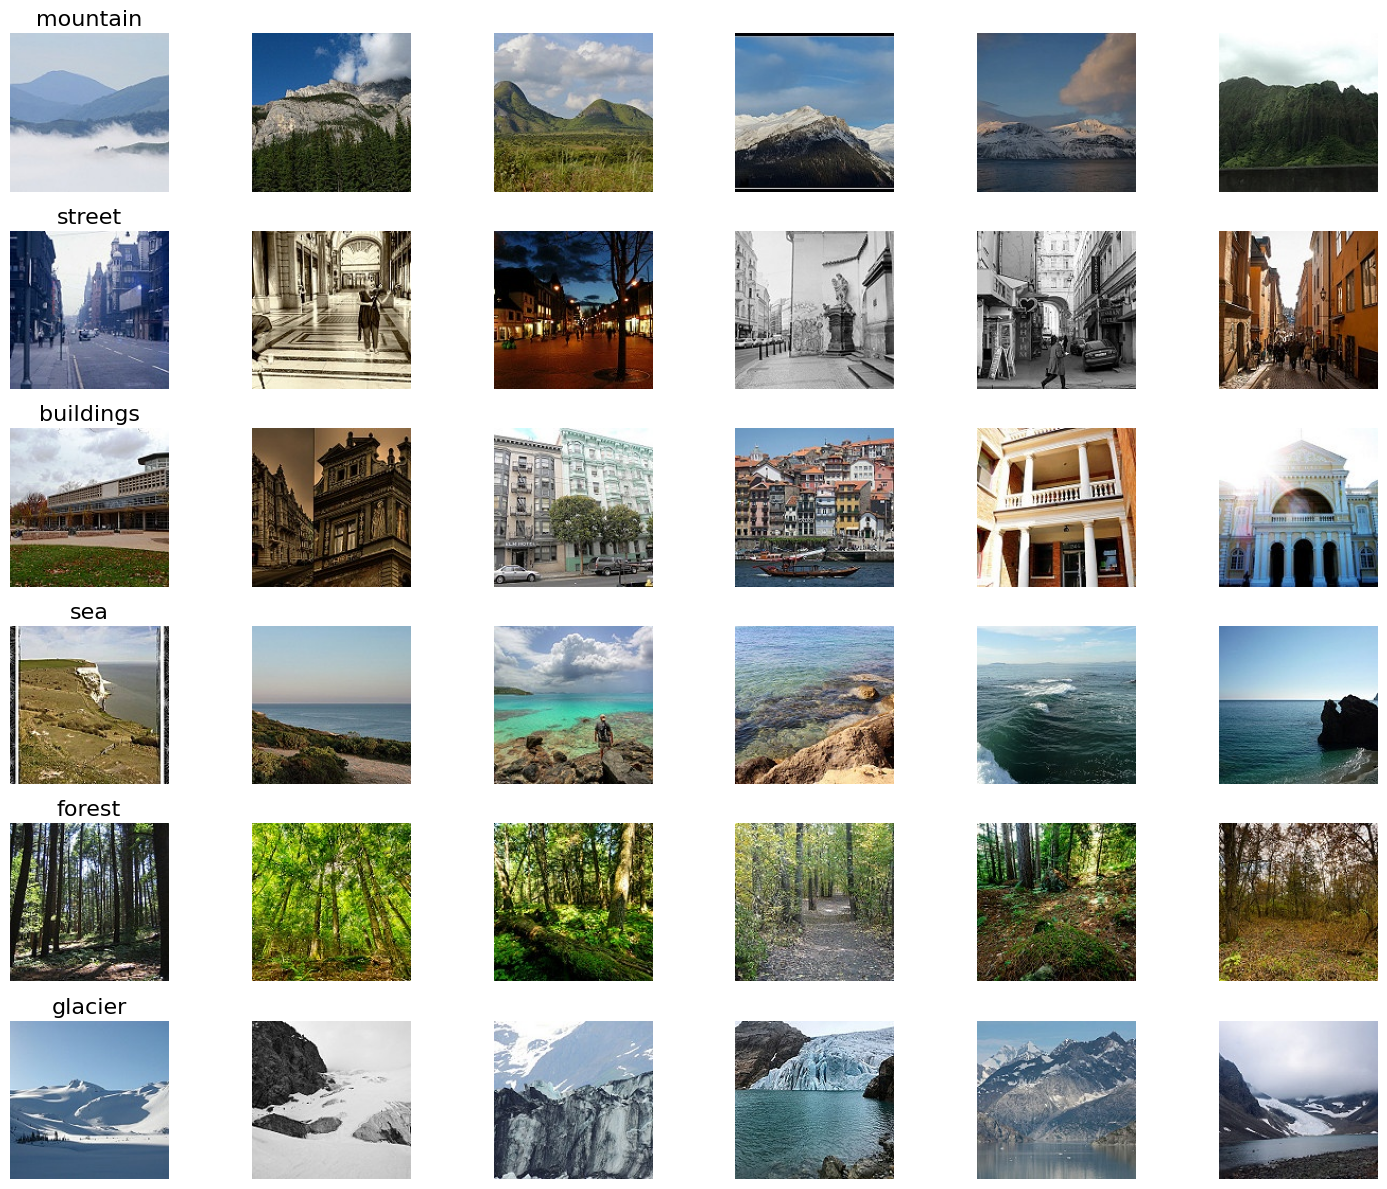

In [ ]:
# Define the train directory path
train_dir = '/kaggle/input/intel-image-classification/seg_train/seg_train'

# Class names (assuming the directory names are the class labels)
class_names = os.listdir(train_dir)

# Number of classes
num_classes = len(class_names)

# Number of images to display per class
num_images_per_class = 6

# Set up the matplotlib figure and axes
fig, axes = plt.subplots(num_classes, num_images_per_class, figsize=(15, num_classes * 2))

for i, class_name in enumerate(class_names):
    class_dir = os.path.join(train_dir, class_name)
    image_files = os.listdir(class_dir)[:num_images_per_class]  # Get first few images

    for j, image_file in enumerate(image_files):
        img_path = os.path.join(class_dir, image_file)
        img = load_img(img_path, target_size=(150, 150))
        img_array = img_to_array(img)
        img_array /= 255.0  # Normalize the image

        axes[i, j].imshow(img_array)
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_title(class_name, size=16)

plt.tight_layout()
plt.show()

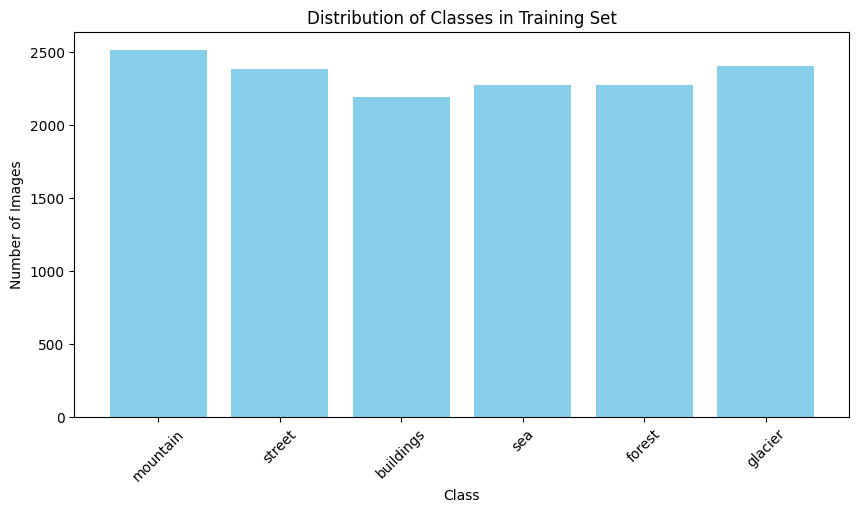

In [ ]:
# Count the number of images in each class
class_counts = {class_name: len(os.listdir(os.path.join(train_dir, class_name))) for class_name in class_names}

# Plot the distribution
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Classes in Training Set')
plt.xticks(rotation=45)
plt.show()

<Figure size 1200x600 with 0 Axes>

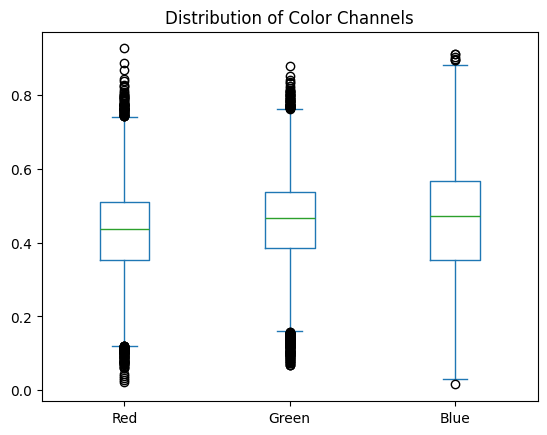

In [ ]:
# Function to get color channel means
def get_color_means(directory):
    means = []
    for subdir, _, files in os.walk(directory):
        for file in files:
            if file.endswith(('jpeg', 'jpg', 'png')):
                img_path = os.path.join(subdir, file)
                img = load_img(img_path, target_size=(150, 150))
                img_array = img_to_array(img) / 255.0
                means.append(img_array.mean(axis=(0, 1)))
    return np.array(means)

# Get color channel means for training dataset
color_means = get_color_means(train_dir)

# Convert to DataFrame for easy plotting
color_df = pd.DataFrame(color_means, columns=['Red', 'Green', 'Blue'])

# Plot color channel distributions
plt.figure(figsize=(12, 6))
color_df.plot(kind='box', title='Distribution of Color Channels')
plt.show()

In [ ]:
# Data augmentation and normalization for training
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2)

# No augmentation for validation
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Create data generators
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=img_size,
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    subset='training')

validation_generator = train_datagen.flow_from_directory(train_dir,
                                                         target_size=img_size,
                                                         batch_size=32,
                                                         class_mode='categorical',
                                                         subset='validation')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=img_size,
                                                  batch_size=32,
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [ ]:
from keras.applications.vgg16 import VGG16
from keras.layers import Input, Dense, Dropout, Flatten
from keras.models import Model
from keras.optimizers import Adam

# Define input shape
input_shape = (150, 150, 3)
inputs = Input(shape=input_shape)

# Load the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=inputs)

# Freeze the base model initially
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the top layers (last 4 convolutional blocks)
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Add custom layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(6, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Display the model summary
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         1,54

 Total params: 19,042,374 (72.64 MB)

 Trainable params: 11,407,110 (43.51 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [ ]:
start_time = time.time()

history = model.fit(
    train_generator,
    epochs=10,
    steps_per_epoch=20,
    validation_data=validation_generator,
    validation_steps=20,
    callbacks=[reduce_lr]
)

end_time = time.time()

training_time = end_time - start_time
print(f"\nTotal training time: {training_time:.2f} seconds")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 150, 150, 3))
  warnings.warn(msg)


20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 538ms/step - accuracy: 0.1695 - loss: 2.3087 - val_accuracy: 0.1906 - val_loss: 1.7658 - learning_rate: 1.0000e-05
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 498ms/step - accuracy: 0.1512 - loss: 2.0928 - val_accuracy: 0.4141 - val_loss: 1.6105 - learning_rate: 1.0000e-05
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 518ms/step - accuracy: 0.2261 - loss: 1.9041 - val_accuracy: 0.5391 - val_loss: 1.5038 - learning_rate: 1.0000e-05
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 811ms/step - accuracy: 0.2705 - loss: 1.7811 - val_accuracy: 0.6281 - val_loss: 1.3718 - learning_rate: 1.0000e-05
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 509ms/step - accuracy: 0.3558 - loss: 1.5549 - val_accuracy: 0.6578 - val_loss: 1.2242 - learning_rate: 1.0000e-05
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 397ms/step - accuracy: 0.3783 - loss: 1.4908 - val_accuracy: 0.6953 - val_loss: 1.0952 - learning_rate: 1.0000e-05
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 441ms/step - accuracy: 0.4674

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.layers import Input, Dense, Dropout, Flatten
from keras.models import Model
from keras.optimizers import Adam

# Define input shape
input_shape = (150, 150, 3)
inputs = Input(shape=input_shape)

# Load the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=inputs)

# Freeze the base model initially
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the top layers (last 4 convolutional blocks)
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Add custom layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(6, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Display the model summary
model.summary()

In [ ]:
start_time = time.time()

history = model.fit(
    train_generator,
    epochs=10,
    steps_per_epoch=20,
    validation_data=validation_generator,
    validation_steps=20,
    callbacks=[reduce_lr]
)

end_time = time.time()

training_time = end_time - start_time
print(f"\nTotal training time: {training_time:.2f} seconds")

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_25']
Received: inputs=Tensor(shape=(None, 150, 150, 3))
  warnings.warn(msg)


20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 511ms/step - accuracy: 0.1757 - loss: 2.3683 - val_accuracy: 0.2656 - val_loss: 1.7182 - learning_rate: 1.0000e-05
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 496ms/step - accuracy: 0.1549 - loss: 2.0659 - val_accuracy: 0.4391 - val_loss: 1.5879 - learning_rate: 1.0000e-05
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 514ms/step - accuracy: 0.2090 - loss: 1.8326 - val_accuracy: 0.5422 - val_loss: 1.4764 - learning_rate: 1.0000e-05
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 545ms/step - accuracy: 0.3121 - loss: 1.6858 - val_accuracy: 0.6250 - val_loss: 1.3528 - learning_rate: 1.0000e-05
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 440ms/step - accuracy: 0.3421 - loss: 1.5932 - val_accuracy: 0.7063 - val_loss: 1.1939 - learning_rate: 1.0000e-05
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 441ms/step - accuracy: 0.4225 - loss: 1.4541 - val_accuracy: 0.7422 - val_loss: 1.0151 - learning_rate: 1.0000e-05
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 419ms/step - accuracy: 0.4531 

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.layers import Input, Dense, Dropout, Flatten
from keras.models import Model
from keras.optimizers import Adam

# Define input shape
input_shape = (150, 150, 3)
inputs = Input(shape=input_shape)

# Load the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=inputs)

# Freeze the base model initially
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the top layers (last 4 convolutional blocks)
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Add custom layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(6, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Display the model summary
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         1,54

 Total params: 19,042,374 (72.64 MB)

 Trainable params: 11,407,110 (43.51 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [ ]:
start_time = time.time()

history = model.fit(
    train_generator,
    epochs=10,
    steps_per_epoch=20,
    validation_data=validation_generator,
    validation_steps=20,
    callbacks=[reduce_lr]
)

end_time = time.time()

training_time = end_time - start_time
print(f"\nTotal training time: {training_time:.2f} seconds")

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 550ms/step - accuracy: 0.7914 - loss: 0.5732 - val_accuracy: 0.8500 - val_loss: 0.4546 - learning_rate: 1.0000e-05
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7363 - loss: 0.7553 - val_accuracy: 0.8391 - val_loss: 0.4590 - learning_rate: 1.0000e-05
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 492ms/step - accuracy: 0.7880 - loss: 0.6431 - val_accuracy: 0.8391 - val_loss: 0.4636 - learning_rate: 1.0000e-05
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 465ms/step - accuracy: 0.7922 - loss: 0.6321 - val_accuracy: 0.8406 - val_loss: 0.4281 - learning_rate: 1.0000e-05
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 426ms/step - accuracy: 0.7727 - loss: 0.5787 - val_accuracy: 0.8406 - val_loss: 0.4314 - learning_rate: 1.0000e-05
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 467ms/step - accuracy: 0.7799 - loss: 0.5864 - val_accuracy: 0.8531 - val_loss: 0.4173 - learning_rate: 1.0000e-05
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 466ms/step - accuracy: 0

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define input shape
input_shape = (150, 150, 3)
inputs = Input(shape=input_shape)

# Load the ResNet50 model
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)

# Freeze the base model initially
base_model.trainable = False

# Add a classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the full model
model_50 = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model_50.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callback for reduce a learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

model_50.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 156, 156,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 75, 75,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 75, 75,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 75, 75,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 77, 77,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 38, 38,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 38, 38,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 38, 38,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 38, 38,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 38, 38,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 38, 38,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 38, 38,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 38, 38,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 38, 38,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_3_c

 Total params: 24,113,798 (91.99 MB)

 Trainable params: 526,086 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
start_time = time.time()

history_50 = model_50.fit(
    train_generator,
    epochs=10,
    steps_per_epoch=20,
    validation_data=validation_generator,
    validation_steps=20,
    callbacks=[reduce_lr]
)

end_time = time.time()

training_time = end_time - start_time
print(f"\nTotal training time: {training_time:.2f} seconds")

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 26s 693ms/step - accuracy: 0.1981 - loss: 1.9545 - val_accuracy: 0.1688 - val_loss: 1.7586 - learning_rate: 0.0010
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 486ms/step - accuracy: 0.1954 - loss: 1.7934 - val_accuracy: 0.2359 - val_loss: 1.7278 - learning_rate: 0.0010
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 532ms/step - accuracy: 0.2285 - loss: 1.7413 - val_accuracy: 0.2516 - val_loss: 1.7099 - learning_rate: 0.0010
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 440ms/step - accuracy: 0.2701 - loss: 1.7036 - val_accuracy: 0.3063 - val_loss: 1.6689 - learning_rate: 0.0010
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 673ms/step - accuracy: 0.2790 - loss: 1.6908 - val_accuracy: 0.2062 - val_loss: 1.6714 - learning_rate: 0.0010
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 540ms/step - accuracy: 0.2504 - loss: 1.7137 - val_accuracy: 0.2812 - val_loss: 1.6587 - learning_rate: 0.0010
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.2655 - loss: 1.691

In [ ]:
from tabulate import tabulate
result_df = pd.DataFrame(history.history)
print(tabulate(result_df, headers='keys', tablefmt='psql'))

+----+------------+----------+----------------+------------+-----------------+
|    |   accuracy |     loss |   val_accuracy |   val_loss |   learning_rate |
|----+------------+----------+----------------+------------+-----------------|
|  0 |   0.778125 | 0.59576  |       0.85     |   0.454631 |           1e-05 |
|  1 |   0.74375  | 0.70436  |       0.839063 |   0.458952 |           1e-05 |
|  2 |   0.760938 | 0.687419 |       0.839063 |   0.463605 |           1e-05 |
|  3 |   0.782812 | 0.613753 |       0.840625 |   0.428077 |           1e-05 |
|  4 |   0.778125 | 0.59754  |       0.840625 |   0.431373 |           1e-05 |
|  5 |   0.770312 | 0.614128 |       0.853125 |   0.417275 |           1e-05 |
|  6 |   0.7875   | 0.588146 |       0.851562 |   0.418576 |           1e-05 |
|  7 |   0.801562 | 0.555628 |       0.848437 |   0.453534 |           1e-05 |
|  8 |   0.801562 | 0.549981 |       0.8375   |   0.428983 |           1e-05 |
|  9 |   0.83125  | 0.490516 |       0.854688 |   0.

In [ ]:
from tabulate import tabulate
result_df_50 = pd.DataFrame(history_50.history)
print(tabulate(result_df_50, headers='keys', tablefmt='psql'))

+----+------------+---------+----------------+------------+-----------------+
|    |   accuracy |    loss |   val_accuracy |   val_loss |   learning_rate |
|----+------------+---------+----------------+------------+-----------------|
|  0 |   0.204688 | 1.91531 |       0.16875  |    1.75865 |           0.001 |
|  1 |   0.221875 | 1.77786 |       0.235938 |    1.72784 |           0.001 |
|  2 |   0.217187 | 1.74195 |       0.251563 |    1.70993 |           0.001 |
|  3 |   0.248437 | 1.72292 |       0.30625  |    1.66891 |           0.001 |
|  4 |   0.299373 | 1.67195 |       0.20625  |    1.67141 |           0.001 |
|  5 |   0.267188 | 1.68336 |       0.28125  |    1.65873 |           0.001 |
|  6 |   0.275    | 1.68554 |       0.357812 |    1.63424 |           0.001 |
|  7 |   0.292188 | 1.64636 |       0.329688 |    1.61907 |           0.001 |
|  8 |   0.317187 | 1.64575 |       0.326562 |    1.58943 |           0.001 |
|  9 |   0.295312 | 1.6156  |       0.278125 |    1.58062 |     

In [ ]:
def plot_training_results(result_df, figsize=(18, 4), colors=('#677D6A', '#D6BD98')):
    x = np.arange(len(result_df))

    fig, ax = plt.subplots(1, 3, figsize=figsize)
    fig.suptitle('Model Performance', fontsize=16)

    # ax[0] ---> Accuracy
    ax[0].plot(x, result_df.accuracy, label='Train Accuracy', linewidth=2, color=colors[0])
    ax[0].plot(x, result_df.val_accuracy, label='Validation Accuracy', linewidth=2, linestyle='--', color=colors[1])
    ax[0].set_title('Accuracy', fontsize=14)
    ax[0].set_yticks(np.arange(0.6, 1.01, 0.05))
    ax[0].set_xticks(np.arange(0, len(result_df), 2))
    ax[0].set_xlabel('Epochs', fontsize=12)
    ax[0].set_ylabel('Accuracy', fontsize=12)
    ax[0].legend()
    ax[0].grid(True)

    # ax[1] ---> Loss
    ax[1].plot(x, result_df.loss, label='Train Loss', linewidth=2, color=colors[0])
    ax[1].plot(x, result_df.val_loss, label='Validation Loss', linewidth=2, linestyle='--', color=colors[1])
    ax[1].set_title('Loss', fontsize=14)
    ax[1].set_xticks(np.arange(0, len(result_df), 2))
    ax[1].set_yticks(np.arange(0, 2, 0.2))
    ax[1].set_xlabel('Epochs', fontsize=12)
    ax[1].set_ylabel('Loss', fontsize=12)
    ax[1].legend()
    ax[1].grid(True)

    # ax[2] ---> Learning Rate
    ax[2].plot(x, result_df.learning_rate, label='Learning Rate', linewidth=2, marker='o', color=colors[0])
    ax[2].set_title('Learning Rate', fontsize=14)
    ax[2].set_xticks(np.arange(0, len(result_df), 2))
    ax[2].set_xlabel('Epochs', fontsize=12)
    ax[2].set_ylabel('Learning Rate', fontsize=12)
    ax[2].legend()
    ax[2].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

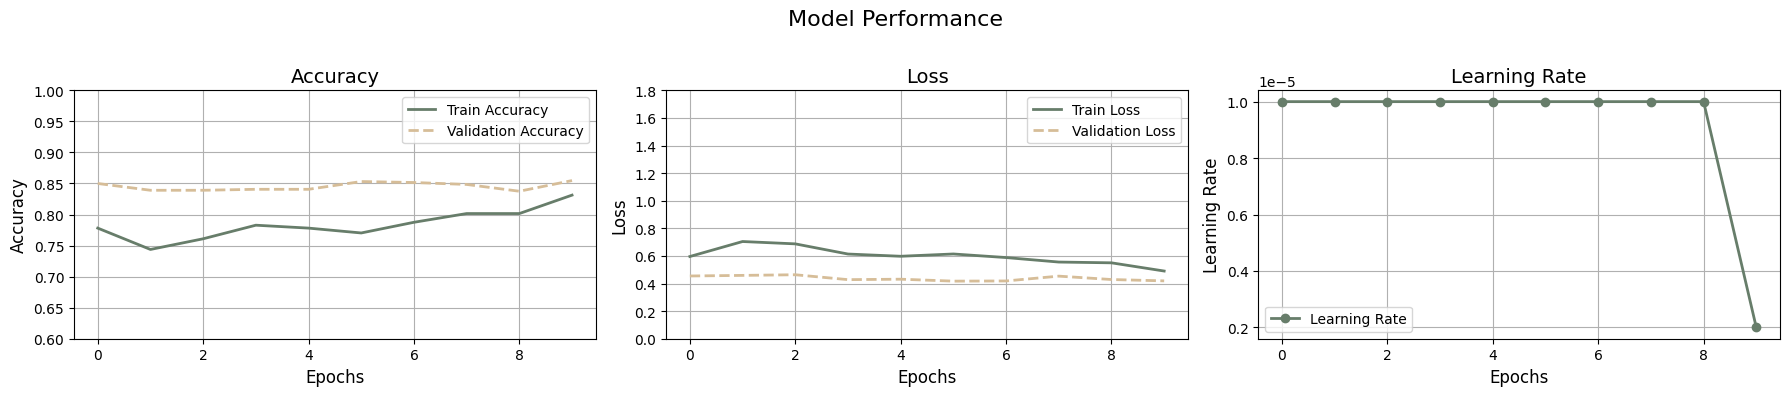

In [ ]:
plot_training_results(result_df)

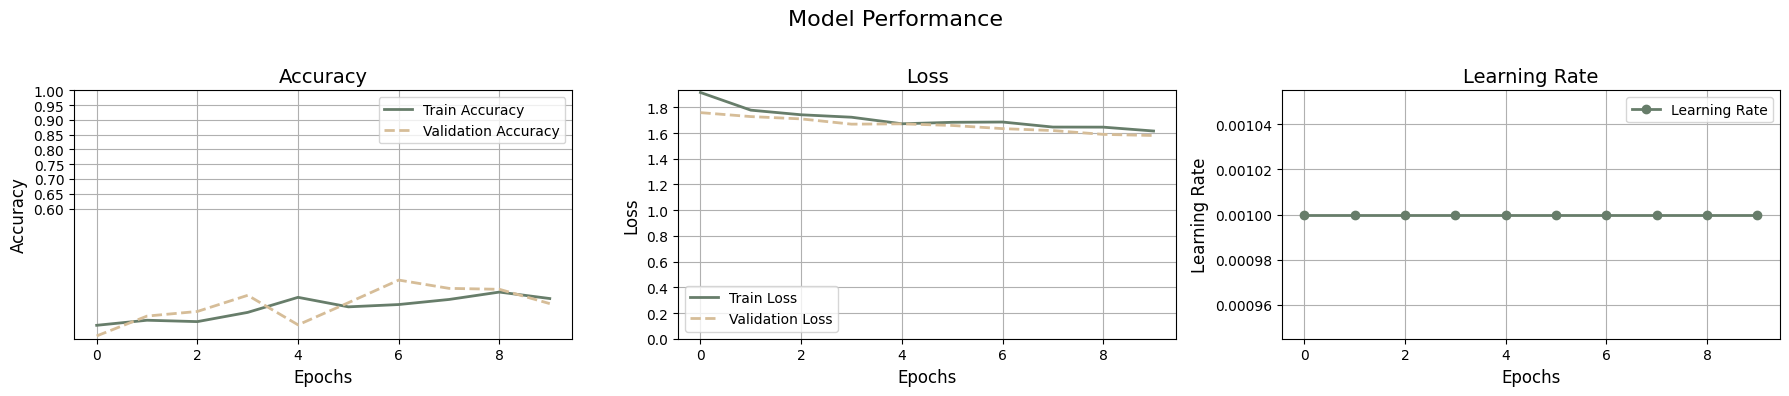

In [ ]:
plot_training_results(result_df_50)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


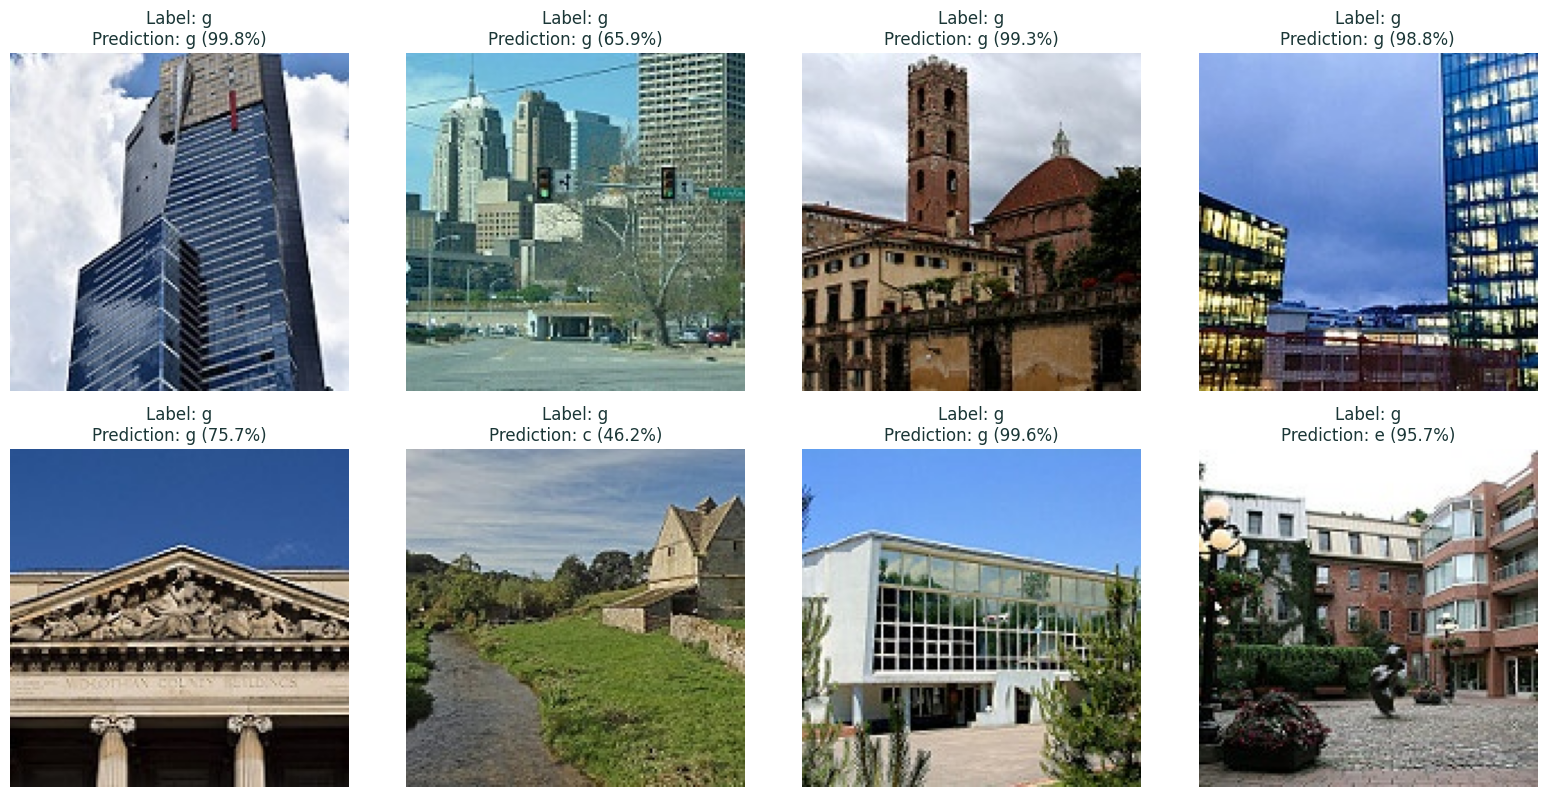

In [ ]:
test_generator.reset()

img, label = next(test_generator)

predictions = model.predict(img)

test_pred_classes = np.argmax(predictions, axis=1)

plt.figure(figsize=[16, 16])

for i in range(8):
    plt.subplot(4, 4, i + 1)
    plt.imshow(img[i])
    plt.axis('off')

    plt.title(f"Label: {class_name[np.argmax(label[i])]}\n"
              f"Prediction: {class_name[test_pred_classes[i]]} "
              f"({100 * np.max(predictions[i]):.1f}%)",
              fontsize=12, color='#1A3636')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


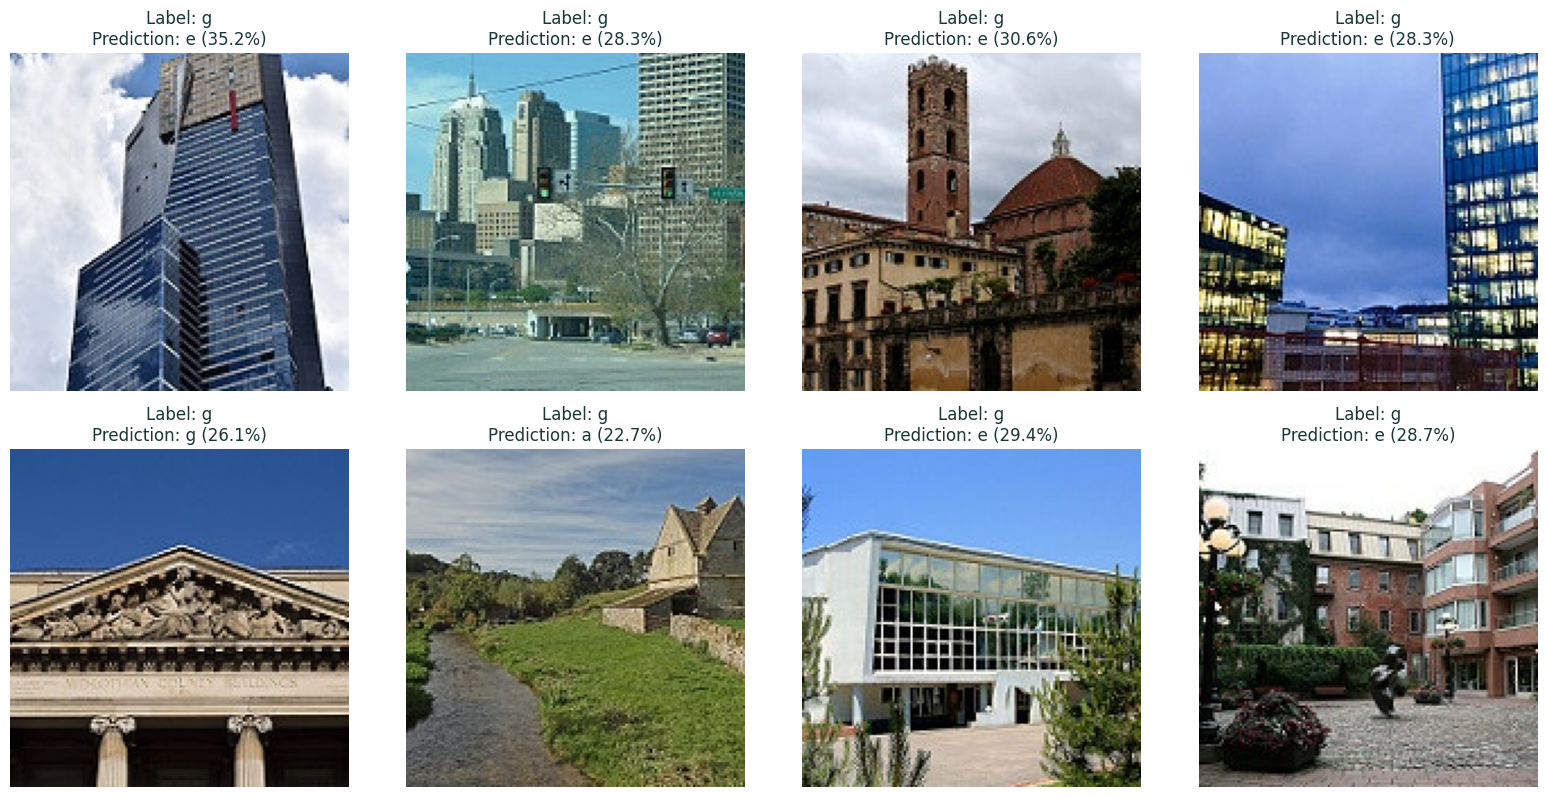

In [ ]:
test_generator.reset()

img, label = next(test_generator)

predictions = model_50.predict(img)

test_pred_classes = np.argmax(predictions, axis=1)

plt.figure(figsize=[16, 16])

for i in range(8):
    plt.subplot(4, 4, i + 1)
    plt.imshow(img[i])
    plt.axis('off')

    plt.title(f"Label: {class_name[np.argmax(label[i])]}\n"
              f"Prediction: {class_name[test_pred_classes[i]]} "
              f"({100 * np.max(predictions[i]):.1f}%)",
              fontsize=12, color='#1A3636')

plt.tight_layout()
plt.show()

In [ ]:
print("Generating predictions on the test set...")
y_pred = model.predict(test_generator, verbose=1)

y_pred_classes = np.argmax(y_pred, axis=1)

print("\nClassification Report:")
clf = classification_report(test_generator.classes, y_pred_classes, target_names=list(class_name)[0:6])

print("="*50)
print("Detailed Classification Report")
print("="*50)
print(clf)
print("="*50)

Generating predictions on the test set...
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step

Classification Report:
Detailed Classification Report
              precision    recall  f1-score   support

           g       0.86      0.90      0.88       437
           l       0.97      0.99      0.98       474
           a       0.78      0.84      0.81       553
           c       0.80      0.79      0.80       525
           i       0.87      0.80      0.83       510
           e       0.91      0.88      0.90       501

    accuracy                           0.86      3000
   macro avg       0.87      0.87      0.87      3000
weighted avg       0.86      0.86      0.86      3000



In [ ]:
print("Generating predictions on the test set...")
y_pred_50 = model_50.predict(test_generator, verbose=1)

y_pred_classes_50 = np.argmax(y_pred, axis=1)

print("\nClassification Report:")
clf = classification_report(test_generator.classes, y_pred_classes_50, target_names=list(class_name)[0:6])

print("="*50)
print("Detailed Classification Report")
print("="*50)
print(clf)
print("="*50)

Generating predictions on the test set...
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step

Classification Report:
Detailed Classification Report
              precision    recall  f1-score   support

           g       0.86      0.90      0.88       437
           l       0.97      0.99      0.98       474
           a       0.78      0.84      0.81       553
           c       0.80      0.79      0.80       525
           i       0.87      0.80      0.83       510
           e       0.91      0.88      0.90       501

    accuracy                           0.86      3000
   macro avg       0.87      0.87      0.87      3000
weighted avg       0.86      0.86      0.86      3000



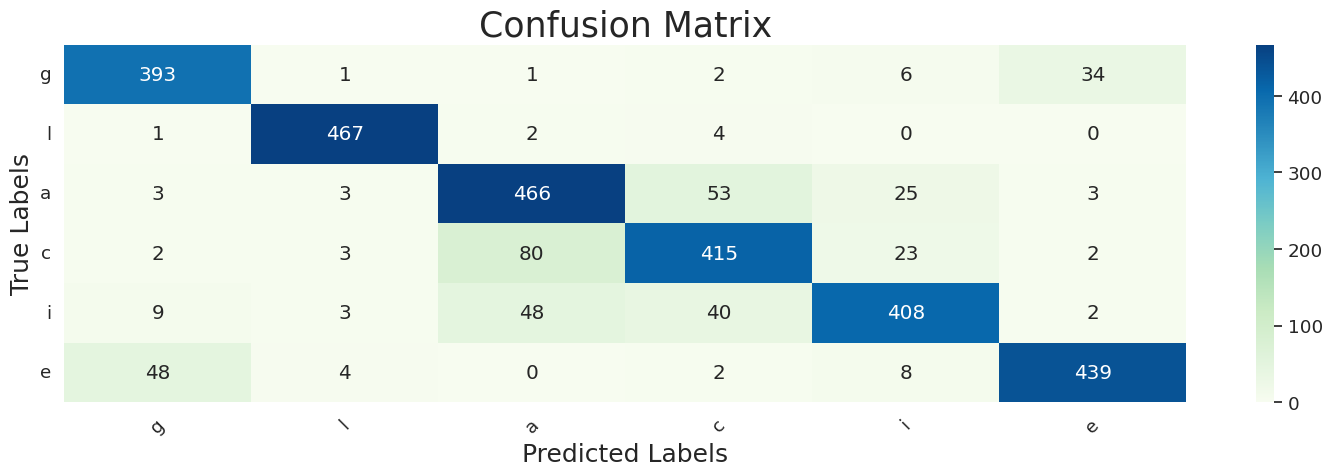

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
    """Plot the confusion matrix for the classification results."""

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(15, 5))
    sns.set(font_scale=1.2)

    ax = sns.heatmap(cm, annot=True, fmt='g', cmap="GnBu", cbar=True)

    ax.set_xlabel('Predicted Labels', fontsize=18)
    ax.set_ylabel('True Labels', fontsize=18)
    ax.set_title('Confusion Matrix', fontsize=25)

    ax.xaxis.set_ticklabels(class_name[0:6], rotation=45)
    ax.yaxis.set_ticklabels(class_name[0:6], rotation=0)

    plt.tight_layout()
    plt.show()

plot_confusion_matrix(test_generator.classes, y_pred_classes)

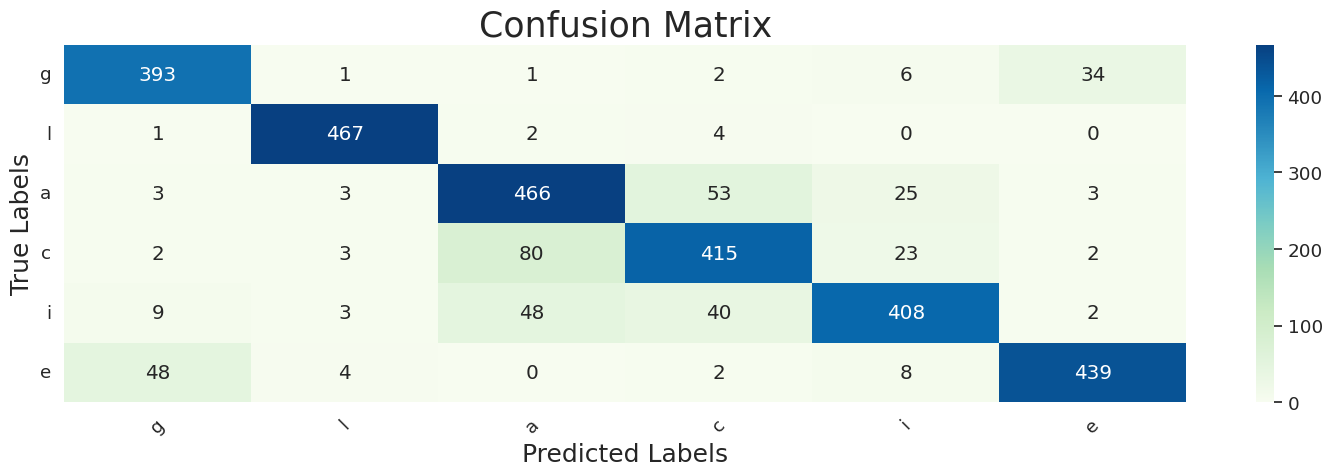

In [ ]:
plot_confusion_matrix(test_generator.classes, y_pred_classes_50)